In [86]:
import argparse
import pickle
from collections import namedtuple
import copy

import matplotlib.transforms as trs
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import patches
from matplotlib import animation
from IPython.display import HTML
# install package for displaying animation
!pip install JSAnimation

%matplotlib inline

import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler


# Hyper-Parameters

In [101]:
n=2
gamma=0.9
seed=0
render=True
log_interval=100
T = 100
num_H = 0
num_O = 4 + num_H * 2
num_A = 2

TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'a_log_p', 'r', 's_'])

# Neural Networks

In [88]:
class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc = nn.Linear(num_O, 100)
        self.mu_head = nn.Linear(100, num_A)
        self.sigma_head = nn.Linear(100, num_A)

    def forward(self, x):
        x = F.relu(self.fc(x))
        mu = torch.tanh(self.mu_head(x))
        sigma = F.softplus(self.sigma_head(x))
        mu = torch.clamp(mu, 1e-10)
        sigma = torch.clamp(sigma, 1e-10)
        return (mu, sigma)


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc = nn.Linear(num_O, 100)
        self.v_head = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        state_value = self.v_head(x)
        return state_value

# Agent

In [102]:
class Agent():

    clip_param = 0.2
    max_grad_norm = 0.5
    ppo_epoch = 10
    buffer_capacity, batch_size = 1000, 128

    def __init__(self):
        self.training_step = 0
        self.anet = ActorNet().float()
        self.cnet = CriticNet().float()
        self.buffer = []
        self.counter = 0

        self.optimizer_a = optim.Adam(self.anet.parameters(), lr=1e-4)
        self.optimizer_c = optim.Adam(self.cnet.parameters(), lr=3e-4)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            (mu, sigma) = self.anet(state)
        dist = Normal(mu, sigma)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
        action.clamp(-2.0, 2.0)
        return action.view(-1).numpy(), action_log_prob.view(-1).numpy()

    def get_value(self, state):

        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            state_value = self.cnet(state)
        return state_value.item()

    def save_param(self):
        torch.save(self.anet.state_dict(), 'param/ppo_anet_params.pkl')
        torch.save(self.cnet.state_dict(), 'param/ppo_cnet_params.pkl')

    def store(self, transition):
        self.buffer.append(transition)
        self.counter += 1
        return self.counter % self.buffer_capacity == 0

    def update(self):
        self.training_step += 1

        s = torch.tensor([t.s for t in self.buffer], dtype=torch.float)
        a = torch.cat([torch.from_numpy(t.a.reshape(1,2)) for t in self.buffer], dim=0)
        r = torch.tensor([t.r for t in self.buffer], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in self.buffer], dtype=torch.float)

        old_action_log_probs = torch.cat(
            [torch.from_numpy(t.a_log_p.reshape(1,2)) for t in self.buffer], dim=0).view(-1, 2)

        r = (r - r.mean()) / (r.std() + 1e-5)
        with torch.no_grad():
            target_v = r + gamma * self.cnet(s_)

        adv = (target_v - self.cnet(s)).detach()

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(
                    SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):

                (mu, sigma) = self.anet(s[index])
                dist = Normal(mu, sigma)
                action_log_probs = dist.log_prob(a[index])
                ratio = torch.exp(action_log_probs - old_action_log_probs[index])

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()

                self.optimizer_a.zero_grad()
                action_loss.backward()
                nn.utils.clip_grad_norm_(self.anet.parameters(), self.max_grad_norm)
                self.optimizer_a.step()

                value_loss = F.smooth_l1_loss(self.cnet(s[index]), target_v[index])
                self.optimizer_c.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.cnet.parameters(), self.max_grad_norm)
                self.optimizer_c.step()

        del self.buffer[:]

In [103]:
class RobotEnv(gym.Env):
  def __init__(self,n):
    self.n=n

  def step(self, action_n):
    for i in range(self.n):
      v, r = action_n[i]
      px, py = self.state_n[i][0:2]
      theta = self.state_n[i][2] + r
      px = px + v * np.cos(theta)
      py = py + v * np.sin(theta)

      self.state_n[i] = np.array([px, py, theta])

    cost_n=[]
    for i in range(self.n):
      dist = np.linalg.norm(self.goal_n[i] - self.state_n[i][:2])
      if dist < 0.5: 
        cost = 10
      else: 
        cost = -1*dist
      cost_n.append(cost)

    return self._get_obs(), cost_n, False, {}

  def _get_obs(self):
    obs_n = []
    for i in range(self.n):
      dist = self.goal_n[i] - self.state_n[i][:2]
      theta = self.state_n[i][2]
      heading = np.array([np.cos(theta), np.sin(theta)])
      obs_n.append(np.hstack([dist, heading]))
    return obs_n
    
  def reset(self):
    self.state_n = []
    self.goal_n = []
    for i in range(self.n):
      theta = i * (np.pi * 2 / n) + np.pi / 2
      radius = 5
      sT = np.array([np.cos(theta), np.sin(theta)]) * radius
      s0 = np.array([-np.cos(theta), -np.sin(theta)]) * radius
      state = np.hstack([s0, theta])
      self.state_n.append(state)
      self.goal_n.append(sT)
    return self._get_obs()

  def render(self, path):
    self.fig, self.ax = plt.subplots(figsize=(7, 7))
    for i in range(self.n):
      x, y, theta = self.state_n[i]
      
      robot = plt.Circle([x,y], 0.5, fill=True, color='y')
      self.ax.add_artist(robot)
      robot.center = [x,y]

      vertices =[(-1/4,0), (1/4,0), (0, 1/2)] 
      polygon = patches.Polygon(vertices, color="red", alpha=0.50) 
      self.ax.add_artist(polygon)
      r = trs.Affine2D().rotate(theta-np.pi/2)
      t = trs.Affine2D().translate(x, y)
      tra = r + t + self.ax.transData
      polygon.set_transform(tra)
      x, y = self.goal_n[i]
      self.ax.add_artist(mlines.Line2D([x],[y], color='r', marker='*', linestyle='None', markersize=15, label='Goal'))  

      self.ax.scatter(path[:,i, 0], path[:,i,1])
    
    self.ax.set_xlabel('x(m)', fontsize=16)
    self.ax.set_ylabel('y(m)', fontsize=16)
    self.ax.set_xlim(-7, 7)
    self.ax.set_ylim(-7, 7)
    plt.show()

# Random Agent

In [91]:

env = RobotEnv(n)
#agents = [Agent() for _ in range(n)]

obs_n = env.reset()
traj = []

for t in range(T):
    traj.append(np.asarray(env.state_n).copy())
    action_n = []
    for i in range(n):
      agent = agents[i]
      action, action_log_prob = agent.select_action(obs_n[i])
      action_n.append(action)
    obs_n_, reward, done, _ = env.step(action_n)
    # env.render(np.asarray(traj))
    obs_n = obs_n_

# Training

Ep 0	 Score: -1857.50
Ep 100	 Score: -1867.87
Ep 200	 Score: -2883.50
Ep 300	 Score: -536.16
Ep 400	 Score: -147.10
Ep 500	 Score: 100.05
Ep 600	 Score: 571.07
Ep 700	 Score: 1118.57
Ep 800	 Score: 1681.96
Ep 900	 Score: 1677.90


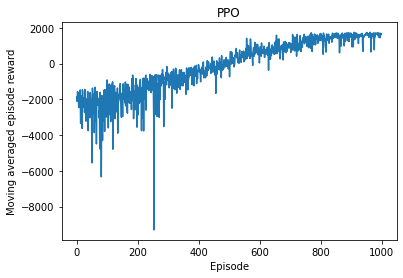

In [104]:
env = RobotEnv(n)
env.seed(seed)

agents = [Agent() for _ in range(n)]

training_records = []
obs_n = env.reset()

for i_ep in range(1000):
    score = 0
    obs_n = env.reset()
    for t in range(T):
      action_n = []
      action_log_prob_n=[]
      for i in range(n):
        agent = agents[i]
        action, action_log_prob = agent.select_action(obs_n[i])
        action_n.append(action)
        action_log_prob_n.append(action_log_prob)
        
      obs_n_, reward, done, _ = env.step(action_n)
      for i in range(n):
        agent = agents[i]
        if agent.store(Transition(obs_n[i], action_n[i], action_log_prob_n[i], reward[i], obs_n_[i])):
            agent.update()
      score += np.asarray(reward).sum()
      obs_n = obs_n_

    training_records.append(TrainingRecord(i_ep, score))

    if i_ep % log_interval == 0:
        print(f'Ep {i_ep}\t Score: {score:.2f}')

plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
plt.title('PPO')
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.show()


# Testing (video)

In [105]:
# env = RobotEnv(n)
obs_n = env.reset()
traj = []

for t in range(T):
    traj.append(np.asarray(env.state_n).copy())
    action_n = []
    for i in range(n):
      agent = agents[i]
      action, action_log_prob = agent.select_action(obs_n[i])
      action_n.append(action)
    obs_n_, reward, done, _ = env.step(action_n)
    # env.render(np.asarray(traj))
    obs_n = obs_n_


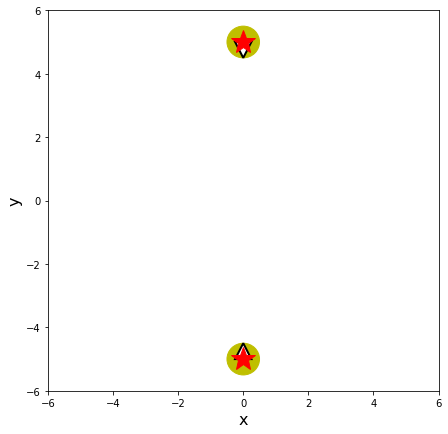

In [106]:
# create a figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

# set up the subplots as needed
ax.set_xlim(( -6, 6))            
ax.set_ylim((-6, 6))
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
txt_title = ax.set_title('')

robots=[]
polygons=[]
for i in range(n):
  x, y, theta = traj[0][i]
  goal_x, goal_y = env.goal_n[i]
  ax.add_artist(mlines.Line2D([goal_x],[goal_y], color='r', marker='*', linestyle='None', markersize=25, label='Goal'))
  robots.append(plt.Circle([x, y], 0.5, fill=True, color='y'))
  ax.add_artist(robots[i])

  vertices =[(-1/4,0), (1/4,0), (0, 1/2)] 
  polygon = patches.Polygon(vertices, fc=(1,1,1,1), ec=(0,0,0,1), lw=2) 
  ax.add_artist(polygon)
  polygons.append(polygon)
  r = trs.Affine2D().rotate(theta-np.pi/2)
  t = trs.Affine2D().translate(x, y)
  tra = r + t + ax.transData
  polygon.set_transform(tra)

line1, = ax.plot([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects
line2, = ax.plot([], [], 'r', lw=2)
line3, = ax.plot([], [], 'g', lw=2)

In [108]:
def drawframe(time, path):
  for i in range(n):
    x, y, theta = path[time][i]
    robots[i].center = [x, y]
    r = trs.Affine2D().rotate(theta-np.pi/2)
    t = trs.Affine2D().translate(x, y)
    tra = r + t + ax.transData
    polygons[i].set_transform(tra)
    txt_title.set_text('Frame = {0:4d}'.format(n))
  line1.set_data(path[:time, 0, 0], path[:time, 0, 1])
  line2.set_data(path[:time, 1, 0], path[:time, 1, 1])
  # line3.set_data(path[:time, 2, 0], path[:time, 2, 1])
  return (line1,line2,line3)

anim = animation.FuncAnimation(fig, drawframe, frames=T, interval=100, blit=True, fargs=(np.asarray(traj), ))
HTML(anim.to_html5_video())

In [109]:
anim.save('myAnimation.gif', writer='pillow', fps=30)

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [111]:
from google.colab import files
files.download("myAnimation.gif") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>